# MVO

In [32]:
import pandas as pd
import numpy as np
import scipy.optimize
from scipy.optimize import minimize
import warnings
import pylab
from datetime import datetime
from pypfopt import plotting
# iFinDPy 试用权限只支持最近5年的历史行情
import akshare as ak 
#https://akshare.xyz/data/index.html 
#https://akshare.xyz/tutorial.html#id1

In [33]:
def report_Q(date):
    current_date=datetime.strptime(date, '%Y%m%d')
    if current_date.month in [1, 2, 3] or (current_date.month == 3 and current_date.day <= 30):
        res = 4
    elif current_date.month in [4, 5, 6] or (current_date.month == 6 and current_date.day <= 29):
        res = 1
    elif current_date.month in [7, 8, 9] or (current_date.month == 9 and current_date.day <= 29):
        res = 2
    else:
        res = 3
    return res



# ! Datasource

In [34]:
today = datetime.today().strftime("%Y-%m-%d") # format '2023-09-08'
today = today.replace('-', '') # format'20230908'
Y=datetime.strptime(today, '%Y%m%d').year
report_Q(today) 

begin = '20120101'
# 1.portfolio = fund + bond + currency etc.
# 000300.SH[沪深300], 华夏智胜先锋股票(LOF)A[501219.SH], 中欧新动力混合(LOF)A[166009.SZ]
#selection1 = ["sh501219","sz166009","sh000300"]
selection1 = ["sh501219","sz166009"] 

# 2.portfolio = equity1 + equity2 + equity3 etc.
selection2 = "501219" # fund code

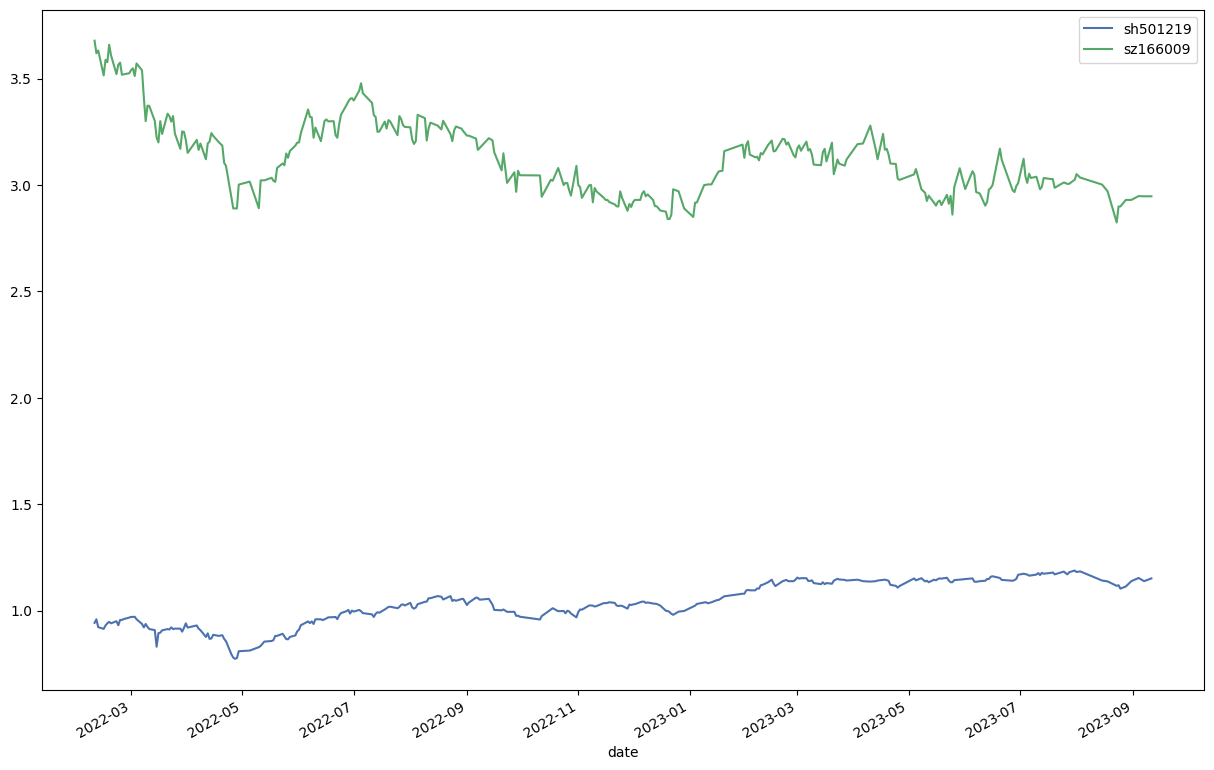

In [35]:
# 1.portfolio = fund + bond + currency etc.
# 股票型基金收盘价 data_fund("sh501219", "20230101", "20230630")[['date']]
def data_fund(code, start, end):
    dataframe_fund = ak.stock_zh_index_daily_em(symbol = code, start_date = start, end_date = end)
    dataframe_fund.insert(0,column=code, value=dataframe_fund['close'])
    return dataframe_fund[['date',code]]
# 导入组合各基金收盘价
# port(["sh000300"], "20120101", "20230630")
# port(["sh000300","sh501219","sz166009"], "20120101", "20230630")
def port(code,start,end):
    res = data_fund(code[0],start,end)[['date']]
    for i in range(0,len(code)):
        dataframe = data_fund(code[i], start, end)
        res = pd.merge(res, dataframe, how='outer', on = 'date') 
    res.rename(columns={'date': 'datetime'}, inplace=True)
    res.insert(0,column='date', value=pd.to_datetime(res['datetime']))
    res.set_index('date', inplace=True)
    res=res.drop('datetime', axis=1)
    return res.dropna() 
# GFC后收盘价走势
def graph(port,datetime):
    port[port.index>= datetime].plot(figsize=(15,10));
    return pylab.show()
portfolio1=port(selection1, begin, today)
graph(portfolio1,"2008-01-01")

In [36]:
portfolio1

,sh501219,sz166009
date,,
2022-02-09,0.943,3.678
2022-02-10,0.960,3.619
2022-02-11,0.923,3.632
2022-02-14,0.915,3.515
2022-02-15,0.931,3.588
...,...,...
2023-08-28,1.114,2.930
2023-08-31,1.139,2.930
2023-09-04,1.154,2.948


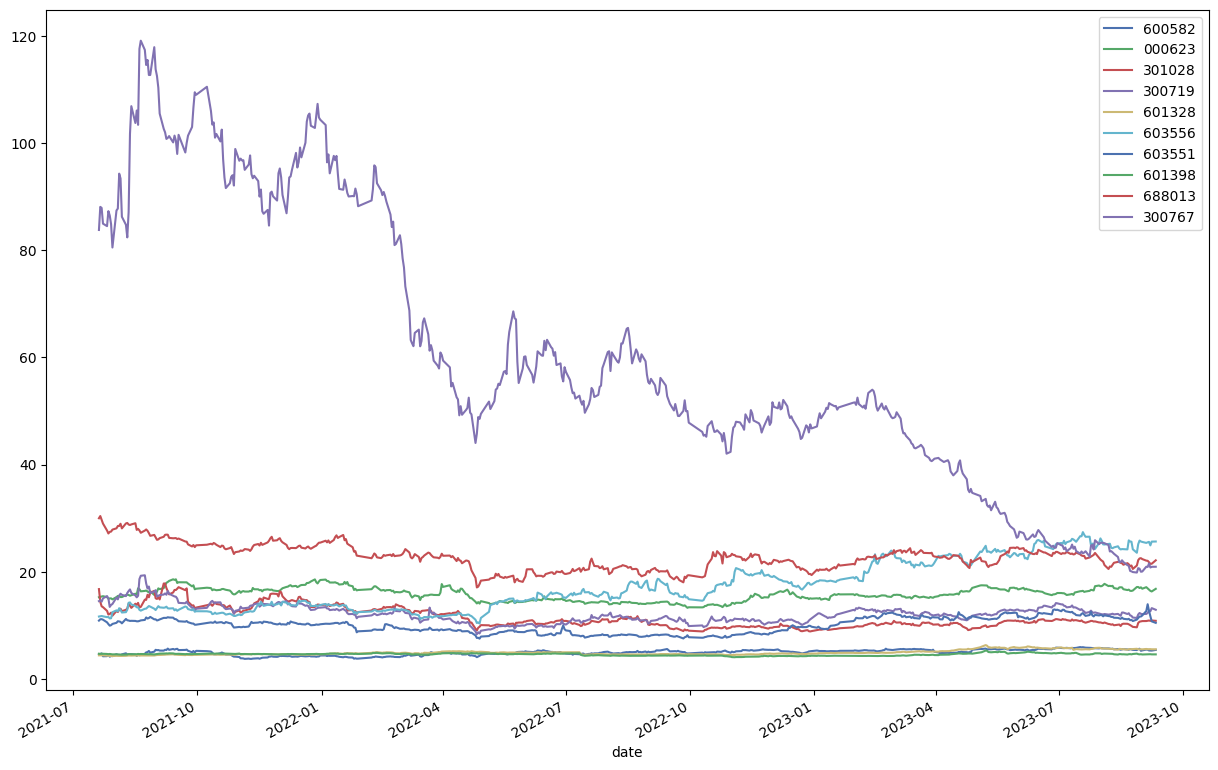

In [37]:
# 2.portfolio = equity1 + equity2 + equity3 etc.
# 股票收盘价 data_equity("600129","20230401",today)
def data_equity(code, start, end):
    dataframe_equity = ak.stock_zh_a_hist(symbol=code, period="daily", start_date = start, end_date = end, adjust="")
    dataframe_equity.insert(0,column=code, value=dataframe_equity['收盘'])
    dataframe_equity.insert(0,column='date', value=dataframe_equity['日期'])
    return dataframe_equity[['date',code]]
# 基金各股票 all_stock("501219","20230301","20230907",2023,1)
def all_stock(fund_code,start,end,year,Q):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    all=ak.fund_portfolio_hold_em(symbol=fund_code, date=year)
    all=all.loc[all['季度'] == str(year)+'年'+str(Q)+'季度股票投资明细']
    all.insert(0,column=fund_code, value=all['股票代码'])
    return all[[fund_code]]
# 前十重仓股票收盘价 portfolio_stock("501219","20170301","20210907",2023,2,10)
def portfolio_stock(fund_code,start,end,year,Q,top_stock):
    stock_list = all_stock(fund_code,start,end,year,Q)
    res = data_equity(stock_list[fund_code][0],start,end)[['date']]
    for i in range(0,top_stock):
        dataframe=pd.DataFrame()
        dataframe = data_equity(stock_list[fund_code][i], start, end)
        res = pd.merge(res, dataframe, how='outer', on = 'date') 
    res.rename(columns={'date': 'datetime'}, inplace=True)
    res.insert(0,column='date', value=pd.to_datetime(res['datetime']))
    res.set_index('date', inplace=True)
    res=res.drop('datetime', axis=1)
    return res.dropna()
# GFC后收盘价走势
portfolio2=portfolio_stock(selection2,begin,today,Y,report_Q(today),10)
def graph(portfolio,datetime):
    portfolio[portfolio.index>= datetime].plot(figsize=(15,10));
    return pylab.show()
graph(portfolio2,"2008-01-01")

In [38]:
portfolio2

,600582,000623,301028,300719,601328,603556,603551,601398,688013,300767
date,,,,,,,,,,
2021-07-20,4.57,15.25,16.77,14.53,4.41,11.65,10.89,4.71,29.99,83.78
2021-07-21,4.65,15.31,14.40,14.69,4.41,11.69,11.14,4.69,30.40,88.09
2021-07-22,4.77,15.38,13.56,14.42,4.41,11.75,11.16,4.71,29.69,87.90
2021-07-23,4.24,15.45,13.40,15.04,4.41,11.69,11.06,4.70,29.00,84.96
2021-07-26,4.26,15.26,12.71,15.47,4.35,11.54,10.57,4.67,27.70,84.50
...,...,...,...,...,...,...,...,...,...,...
2023-09-05,5.46,16.90,10.87,12.32,5.55,25.50,13.95,4.59,22.05,20.90
2023-09-06,5.32,16.67,10.91,12.75,5.56,25.58,12.70,4.61,21.79,21.55
2023-09-07,5.31,16.44,10.84,12.63,5.57,24.93,11.72,4.62,21.48,20.80


# ! Portfolio

In [51]:
portfolio=portfolio1

# Calculation  

returns

In [52]:
def table(portfolio,frequency=252):
    total_return=portfolio.iloc[-1, :] / portfolio.iloc[0, :]
    period=(portfolio.index[-1] - portfolio.index[0]).days/365
    mean=total_return**(1 / period) - 1
    std=(portfolio.pct_change()[1:].std())*np.sqrt(frequency)
    res = pd.DataFrame({"mean":mean,"std": std})
    return res
table(portfolio)

,mean,std
sh501219,0.134507,0.218475
sz166009,-0.130367,0.271952


annual returns

In [53]:
def returns(portfolio,frequency=252):
    total_return=portfolio.iloc[-1, :] / portfolio.iloc[0, :]
    period=(portfolio.index[-1] - portfolio.index[0]).days/365
    mean=total_return**(1 / period) - 1
    std=(portfolio.pct_change()[1:].std())*np.sqrt(frequency)
    res = pd.DataFrame({"mean":mean,"std": std})
    return np.array(mean)
returns(portfolio)

array([ 0.13450713, -0.13036728])

covariance

In [54]:
# calculating the covariance matrix
def covariance(portfolio,frequency=252):
    res = portfolio.pct_change().dropna(how="all").cov()*frequency
    return res 
covariance(portfolio)


,sh501219,sz166009
sh501219,0.047732,0.014277
sz166009,0.014277,0.073958


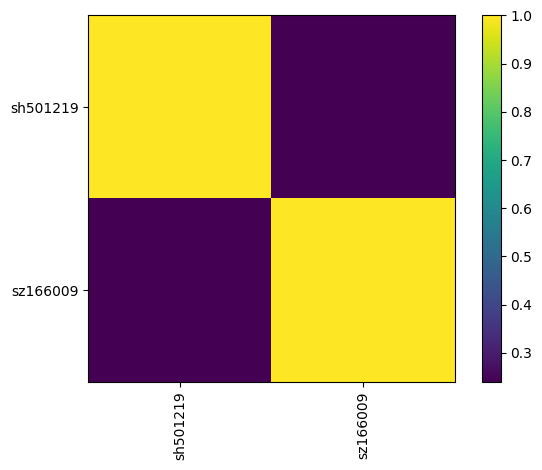

In [55]:
plotting.plot_covariance(covariance(portfolio1), plot_correlation=True);
# pylab.show()

max return

In [70]:
def optimization(returns,cov_matrix,way="max_ret",target=0.1,w1=0.4,w2=0.5):
    n = len(returns) # Total number of assets
    weights = np.ones(n) / n # Initial guess for weights
    bounds = [(0, 1) for _ in range(n)] # Set bounds for weights (between 0 and 1)    
    def asset1_constraint(weights):
        return w1 - weights[0]  # Constraint for asset 1: 0 <= Weight <= w1
    def asset2_constraint(weights):
        return w2 - weights[1]  # Constraint for asset 2: 0 <= Weight <= w2
    constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Full investment constraint
        {'type': 'ineq', 'fun': asset1_constraint},  # Constraint for asset 1
        {'type': 'ineq', 'fun': asset2_constraint}]  # Constraint for asset 2
    
    if way == "max_ret":
        def objective_function(weights, returns): # maximize (portfolio return)
            return -np.sum(returns * weights)  # maximize the negative return
        def risk_constraint(weights, cov_matrix):
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return target - portfolio_volatility  # Constraint: Standard Deviation <= 10%
        constraints = constraints + [{'type': 'ineq', 'fun': risk_constraint, 'args': (cov_matrix,)}]
        result = minimize(objective_function, weights, args=(returns,), method='SLSQP', constraints=constraints, bounds=bounds)
        SD=np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
        return "Optimal Portfolio Weights:"+str(result.x)+". Optimal Portfolio Return:"+str(-result.fun)+". Optimal Portfolio Standard Deviation:"+str(SD)
    elif way == "min_std":
        def objective_function(weights, cov_matrix):
            portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
            return portfolio_variance  # We minimize portfolio variance
        def return_constraint(weights, returns, min_return):
            portfolio_return = np.sum(returns * weights)
            return min_return - portfolio_return  # Constraint: Expected Return >= min_return
        constraints = constraints + [{'type': 'ineq', 'fun': return_constraint, 'args': (returns, target)}]
        result = minimize(objective_function, weights, args=(cov_matrix,), method='SLSQP', constraints=constraints, bounds=bounds)
        return "Optimal Portfolio Weights:"+str(result.x)+". Optimal Portfolio Return:"+str(np.sum(returns * result.x))+". Optimal Portfolio Variance:"+str(result.fun) 
optimization(returns(portfolio),covariance(portfolio))
        

'Optimal Portfolio Weights:[0.5 0.5]. Optimal Portfolio Return:0.0020699278383258662. Optimal Portfolio Standard Deviation:0.1938059154019988'

min std

In [71]:
optimization(returns(portfolio),covariance(portfolio),"min_std")

'Optimal Portfolio Weights:[0.5 0.5]. Optimal Portfolio Return:0.0020699278379752717. Optimal Portfolio Variance:0.03756073284484143'

# Alternative

In [65]:
import pypfopt 
#https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html 
#https://github.com/robertmartin8/PyPortfolioOpt/tree/master/cookbook
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import mean_historical_return

In [66]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.min_volatility() #optimizes for minimum volatility

OrderedDict([('sh501219', 0.6407956753802299),
             ('sz166009', 0.3592043246197702)])

In [67]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.max_sharpe() #optimizes for maximal Sharpe ratio (a.k.a the tangency portfolio)

OrderedDict([('sh501219', 1.0), ('sz166009', 0.0)])

In [68]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.efficient_risk(0.5) #maximises return for a given target risk

OrderedDict([('sh501219', 0.9999999999021612), ('sz166009', 9.77446e-11)])

In [69]:
ef = EfficientFrontier(returns(portfolio), risk_models.sample_cov(portfolio, frequency=252))
ef.efficient_return(0.15) #minimises risk for a given target return

ValueError: target_return must be lower than the maximum possible return